In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import glob #類似開啟檔案的工作
from talib import abstract



./2603_from_20190101_to_20220301.xlsx


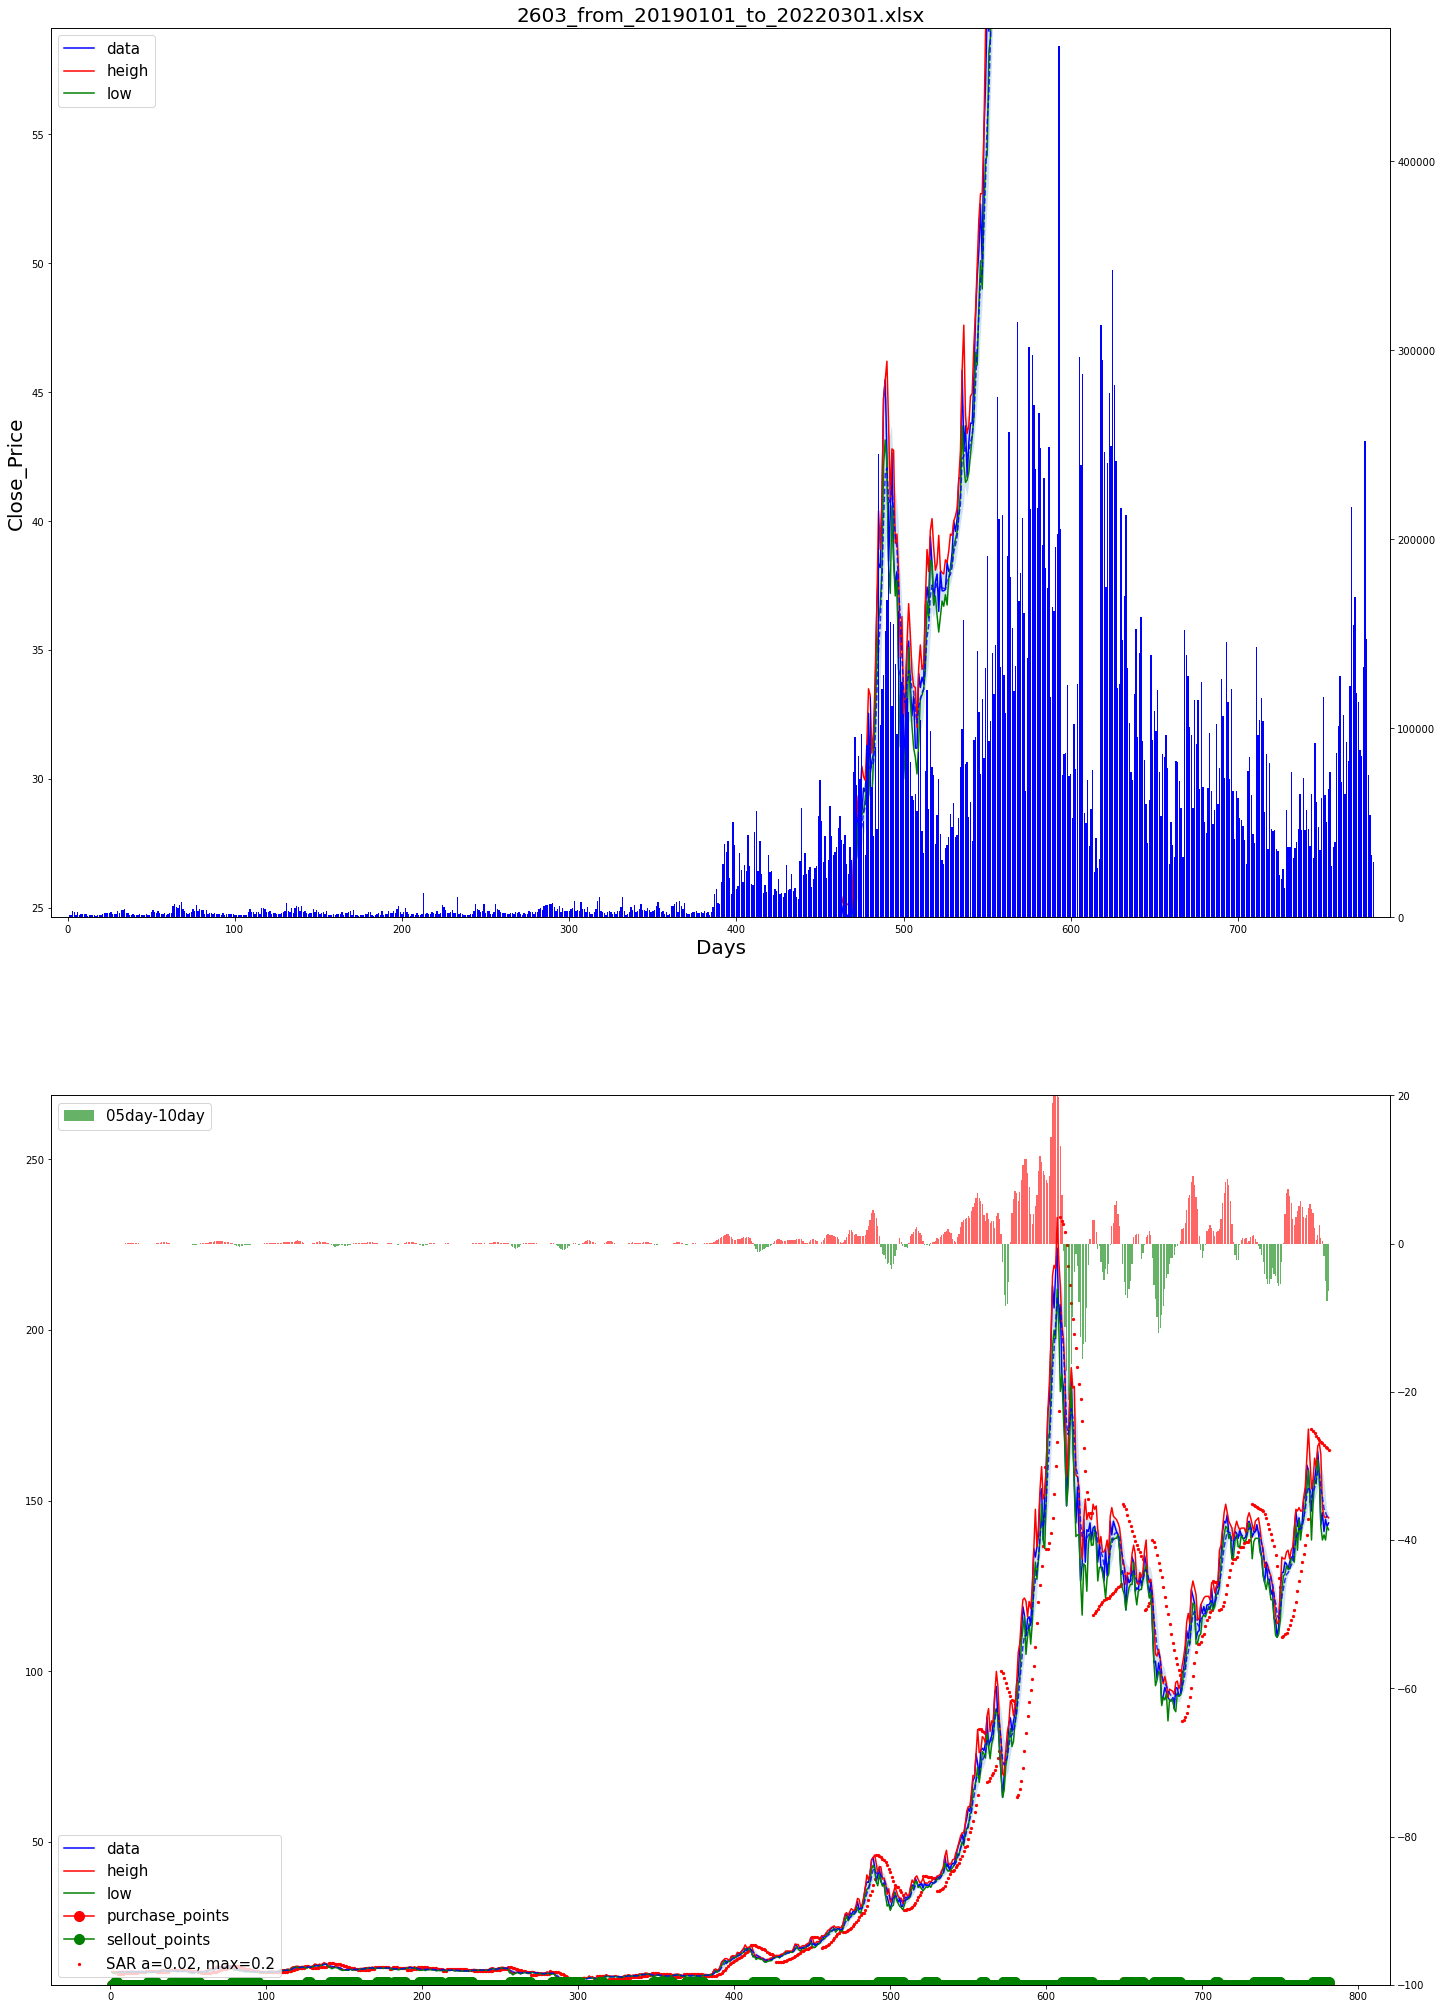

In [16]:
class stock:
    def __init__(self,):
        pass

    def load_df(self,excel_path='./2603_from_20190101_to_20220301.xlsx'):# * 不確定檔名只知道.xlsx
        df=pd.read_excel(excel_path)
        file=excel_path
 
        file=file.replace('./','')
       
        df['收盤價']=df['收盤價'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['最高價']=df['最高價'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['最低價']=df['最低價'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['成交筆數']=df['成交筆數'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['MA05']=df['收盤價'].rolling(5).mean()
        df['MA10']=df['收盤價'].rolling(10).mean()
        df['MA20']=df['收盤價'].rolling(20).mean()
        df['close']=df['收盤價']
        df['high']=df['最高價']
        df['low']=df['最低價']
    
        return df,file

    def cal_talib(self,df):
        global sar,ACCELERATION,MAXIMUM  #全域傳出 就不用再回傳
        df['EMA12']=talib.EMA(np.array(df['收盤價']),timeperiod=12) #吃np.array 
        df['EMA26']=talib.EMA(np.array(df['收盤價']),timeperiod=26)
        df['MACD_DIF'],df['MACD_DEA'],df['MACDhist']=talib.MACD(np.array(df['收盤價']),
                                                        fastperiod=6,
                                                        slowperiod=12,
                                                        signalperiod=9)
        ACCELERATION=0.02
        MAXIMUM=0.2
        sar=talib.SAR(np.array(data_range_heigh),np.array(data_range_low),acceleration=ACCELERATION,maximum=MAXIMUM)
        df['SAR']=sar
        BBAND20=abstract.BBANDS(df,timeperoid=20,nbdevup=1.0,nbdevdn=1.0,matype=1) 
        STOCH=abstract.STOCH(df)
    
        return df,BBAND20,STOCH


    def transfor_df_2_list(self,df):
        data_range_close=df['收盤價'].tolist()
        data_range_heigh=df['最高價'].tolist()
        data_range_low=df['最低價'].tolist()
        data_range_values=df['成交筆數'].tolist()
   
        return data_range_close,data_range_heigh,data_range_low,data_range_values

    def strategy(self,df,STOCH,BBAND20):
        #策略:
        #建立一個買進的訊號:KD在低檔(小於25)黃金交叉,且收價仍在布林通道中線以下
        # K線小於25 and 當日 k>d and 昨天 k<d 且 (收盤價,會在布林中線以下)
        #signal_b=(STOCH['slowk']<25) and (STOCH['slowk']>STOCH['slowd']) and (STOCH['slowk'].shift()<STOCH['slowd'].shift()) and (df['close']<=BBAND20['middleband'])
        #ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
        signal_b=(STOCH['slowk']<25) & (STOCH['slowk']>STOCH['slowd']) & (STOCH['slowk'].shift()<STOCH['slowd'].shift()) & (df['close']<=BBAND20['middleband'])

        #建立一個賣出的訊號:今日收盤卻跌落布林通道上緣,昨日收盤在布林通道上緣
        signal_s=(df['close']<BBAND20['upperband']) & (df['close'].shift()>BBAND20['upperband'].shift())

        #建立一個賣出的訊號:當SAR,昨日在收盤價以下時,今日卻跳到收盤價以上
        signal_s2=(df['SAR']>df['close']) & (df['SAR'].shift()>df['close'].shift())
      
        return signal_b,signal_s,signal_s2

    
    def plot_stock(self,df,BBAND20,STOCH,data_range_close,data_range_heigh,data_range_low,
                   data_range_values,file,plot_page=2,save_path='./my_stock.jpg'):
        t=np.linspace(1,len(data_range_close),len(data_range_close))
        fig=plt.figure(figsize=(24,36)) #設定畫布
        ax1=plt.subplot(211) #畫子圖
        ax1.set_xlim(-10,len(t)+10) #左下角歸0,右下角
        ax1.set_ylim(df['收盤價'].mean()*0.5,df['收盤價'].mean()*1.2) #把數據網上呈現，避免重疊
        ax1.plot(t,data_range_close,color='blue',label='data')
        ax1.plot(t,data_range_heigh,color='red',label='heigh')
        ax1.plot(t,data_range_low,color='green',label='low')
        #畫布林帶
        ax1.plot(t,BBAND20['middleband'],color='blue',linestyle='--',alpha=0.8)
        ax1.fill_between(t,BBAND20['lowerband'],BBAND20['upperband'],alpha=0.2)

        ax1.set_xlabel('Days',fontsize=20)
        ax1.set_ylabel('Close_Price',fontsize=20)
        ax1.set_title(f'{file}',fontsize=20)
        #畫第二個軸
        ax1_2=ax1.twinx()
        ax1_2.bar(t,data_range_values,color='blue',label='Trading volume')
        ax1_2.set_ylim(0,np.array(df['成交筆數']).mean()*10) #把值狀圖往上調整

        ax1.legend(loc=2,prop={'size':15})
        #第二個子圖
        
        if plot_page==2:
            ax2=plt.subplot(212)

            ax2.plot(t,data_range_close,color='blue',label='data')
            ax2.plot(t,data_range_heigh,color='red',label='heigh')
            ax2.plot(t,data_range_low,color='green',label='low')
            ax2.plot(t,BBAND20['middleband'],color='blue',linestyle='--',alpha=0.8)
            ax2.fill_between(t,BBAND20['lowerband'],BBAND20['upperband'],alpha=0.2)
            ax2.scatter(t,sar,s=5,color='red',label=f'SAR a={ACCELERATION}, max={MAXIMUM}' ) 

            ax2.set_ylim(df['收盤價'].min()*0.9,df['收盤價'].max()*1.2)
            #畫買點的圖
            ax2.plot(t,[df['收盤價'].min()*0.9 if b==False else df['收盤價'].min() for  b in signal_b],'r-o',markersize=10,label='purchase_points')
            #畫賣點的圖
            ax2.plot(t,[df['收盤價'].min()*0.9 if s==False else df['收盤價'].min() for  s in signal_s2],'g-o',markersize=10,label='sellout_points')

            ax2.legend(loc=3,prop={'size':15})
            ax2_2=ax2.twinx() #右邊的座標軸
            ax2_2.bar(t
                    ,df['MA05']-df['MA10']
                    ,color=['red' if i>0 else 'green' for i in df['MA05']-df['MA10']]
                    ,alpha=0.6
                    ,label='05day-10day')
            ax2_2.set_ylim(-100,20) 
            ax2_2.legend(loc=2,prop={'size':15})

        plt.savefig(save_path)
        plt.show(fig)

if __name__=='__main__':   
    S=stock()
    #下載資料,做一點資料清洗,轉成df
    df,file=S.load_df(excel_path='./2603_from_20190101_to_20220301.xlsx')
    #因為要畫圖,有些數據轉成list,比較好看
    data_range_close,data_range_heigh,data_range_low,data_range_values=S.transfor_df_2_list(df)
    #計算talib的一些指標
    df,BBAND20,STOCH=S.cal_talib(df)
    #調用策略
    signal_b,signal_s,signal_s2=S.strategy(df,STOCH,BBAND20)
    #畫圖
    S.plot_stock(df,BBAND20,STOCH,data_range_close,data_range_heigh,data_range_low,data_range_values,file,plot_page=2,save_path='./my_stock.jpg')

